In [6]:
!pip3 install --quiet tensorflow-gpu==1.13.1
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet tf-sentencepiece
!pip install tensorboardcolab

import tensorflow as tf
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

import os, sys, datetime
from google.colab import drive
drive.mount('/content/gdrive')
gitDir = "/content/gdrive/My Drive/nlp/"
os.chdir(gitDir)
print(os.listdir("."))

#sys.path.insert(0,gitDir + "data")

import tf_sentencepiece
#import training.train as t
from data import load_dataset
from tqdm import tqdm_notebook as tqdm

import pandas,time
import numpy as np
import tensorflow_hub as hub
from sklearn.metrics import f1_score, confusion_matrix, classification_report,accuracy_score
import matplotlib.pyplot as plt

Version:  1.13.1
Eager mode:  False
GPU is available
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.git', 'README.md', 'data', 'presentations', '.idea', 'training', 'blobs', '.gitignore', '.ipynb_checkpoints', 'imgs', 'report.ipynb']


In [0]:
def getAttributeMapping():
    return {
	'g': 0,
	'p': 1,
	't': 2,
	'q': 3,
	's': 4,
	'h': 5,
	'c': 6,
	'll': 7,
	'or': 8,
	'l': 9,
	'e': 10,
	'av': 11,
	'a': 12,
	'pp': 13
    }

def getEntityMapping():
    return {
	'g': 0,
	'p': 1,
	'f': 2,
	'c': 3,

	'cg': 4,
	'cp': 5,
	'cf': 6,
	'cc': 7,

	'gg': 8
    }

def getRelevanceMapping():
    return {0:0, 9:1}


In [0]:
def hamming_score(y_true, y_pred, normalize=False, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

# train the model

In [38]:
class Model:
    def __init__(self, data_X, data_Y, n_classes, params):
        self.params = params
        self.n_class = n_classes
        self.architecture = params["architecture"][1:]
        #print("Downloading xling...")
        self.xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling/en-de/1", trainable=False)
        self.data_X = data_X
        self.data_Y = data_Y
        self.create_architecture(data_X, data_Y)

    def create_architecture(self, data_X, data_Y):
      
        self.logits = tf.to_float(self.forward(data_X) )
        
        #self.logits = tf.to_float(self.logits)
        #data_Y = tf.to_float(data_Y)
        
        self.labels = tf.to_float(data_Y)

        self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
        self.train_op = self.params["optimizer"].minimize(self.loss)

        self.predictions = tf.to_int32(self.logits > 0.5)
        

        #self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.predictions, tf.cast(data_Y, tf.int64)), tf.float32))

    def forward(self, X):
        output = self.xling(X)

        for index, x in enumerate(self.architecture):
            name = None
            if index == len(self.architecture)-1:
                name = "final_logits"  # specify a name for restoring a saved graph model

            if x == "bn":
                output = tf.layers.batch_normalization(output, training=True, name=name)
            elif x == "relu" or x == "r":
                output = tf.nn.relu(output, name=name)
            elif x == "dropout" or x == "d":
                output = tf.layers.dropout(output, name=name)
            else:
                output = tf.layers.dense(output, x, name=name)

        output = tf.layers.dense(output, self.n_class, name="final_output_prediction")

        return output
      
      

def csvGenerator(filename, attribute, entity, relevance):
    frame = pandas.read_csv(filename.decode("utf-8"), sep='|')
    # print(frame.head())

    if attribute == True:
      frame = frame[frame["Attribute"].notnull()]
    if entity == True:
      frame = frame[frame["Entity"].notnull()]
    if relevance == True:
      frame = frame[frame["Domain_Relevance"].notnull()]
      
      
    #print("Total training rows:", frame.shape)
      
    map_a = getAttributeMapping()
    map_e = getEntityMapping()
    map_r = getRelevanceMapping()
    
    total = 2 + len(map_e) + len(map_a)

    for row in frame.itertuples():
        sentence = getattr(row, "Sentence")
        att = map_a[getattr(row, "Attribute")]
        ent = map_e[getattr(row, "Entity")]
        rel = map_r[getattr(row, "Domain_Relevance")]
        
        label = np.zeros(total)        
        if relevance == True:
          label[rel] = 1          
        if entity == True:
          label[2+ent] = 1         
        if attribute == True:
          label[2+9+att] = 1   
        
        yield sentence, label 



params = {}
params["epochs"] = 15
params["batchSize"] = 256
params["optimizer"] = tf.train.AdamOptimizer(learning_rate=0.001/2)
params["trainexamples"] = None
params["architecture"] = [False]
params["f1modus"] = "micro"
params["savelog"] = False
params["checkpoint"] = False
params["path"] = "blobs/" + "multilabel/"
params["pathToCache"] = "data/"
params["notebook"] = True
params["showPlots"] = True
params["regularization"] = False
params["learning_rate"] = params["optimizer"]._lr
if params["notebook"] == True:
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm as tqdm        
        
        
        
tf.reset_default_graph()
dataset_train = tf.data.Dataset.from_generator(csvGenerator, (tf.string, tf.int32), args=("data/cache/train_test_validation V0.2/train/dataframe.csv", True,True,True) ).batch(256)
dataset_test = tf.data.Dataset.from_generator(csvGenerator, (tf.string, tf.int32), args=("data/cache/train_test_validation V0.2/test/dataframe.csv", True,True,True) ).batch(256)

num_classes = 25

iterator = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)
train_iterator = iterator.make_initializer(dataset_train)
test_iterator = iterator.make_initializer(dataset_test)
text_input, label = iterator.get_next()

model = Model(text_input, label, num_classes, params)

init_op = tf.group([tf.local_variables_initializer(), tf.global_variables_initializer(), tf.tables_initializer()])
sess = tf.Session()
sess.run(init_op)

loss_hist, acc_hist, val_loss_hist, val_acc_hist = [], [], [], []
loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch, f1_train_epoch, f1_val_epoch = [], [], [], [], [], []


lab_pred_hist_train = []
lab_pred_hist_test = []

saver = tf.train.Saver(max_to_keep=5)
startTime = time.time()
for epoch in tqdm(range(params["epochs"])):
    # print('\nEpoch: {}'.format(epoch + 1))
    train_loss, train_accuracy = 0, 0
    val_loss, val_accuracy = 0, 0
    counter = 0

    train_predictions, train_labels, val_predictions, val_labels = [], [], [], []

    sess.run(train_iterator)

    try:
        with tqdm(total=params["trainexamples"]) as pbar:
            while True:
                _, l, predictions, labels = sess.run([model.train_op, model.loss, model.predictions, model.labels])

                train_loss += l
                #train_accuracy += a
                loss_hist.append(l)
                #acc_hist.append(a)
                pbar.set_postfix_str((l))
                pbar.update(params["batchSize"])

                train_predictions.extend(predictions)
                train_labels.extend(labels)

                counter += 1
    except tf.errors.OutOfRangeError:
        pass

    lab_pred_hist_train.append( (train_labels,train_predictions)  )
    
    ### Test set
    train_predictions, train_labels, val_predictions, val_labels = [], [], [], []
    sess.run(test_iterator)
    try:
        with tqdm(total=params["trainexamples"]) as pbar:
            while True:
                predictions, labels = sess.run([model.predictions, model.labels])

                #train_loss += l
                #train_accuracy += a
                #loss_hist.append(l)
                #acc_hist.append(a)
                #pbar.set_postfix_str((l))
                pbar.update(params["batchSize"])

                train_predictions.extend(predictions)
                train_labels.extend(labels)

                counter += 1
    except tf.errors.OutOfRangeError:
        pass

    lab_pred_hist_test.append( (train_labels,train_predictions)  )

#sess.close()
#return result

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0724 08:17:42.349235 139985931245440 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [42]:
labels = np.array(lab_pred_hist_train[-1][0])
preds = np.array(lab_pred_hist_train[-1][1])
labels_test = np.array(lab_pred_hist_test[-1][0])
preds_test = np.array(lab_pred_hist_test[-1][1])
print("hamming:", hamming_score(labels, preds) )
print("hamming test:", hamming_score(labels_test, preds_test) )
print("accuracy:", accuracy_score( labels, preds ))
print("micro f1:", f1_score( labels, preds ,average="micro") )
print("micro f1 test:", f1_score( labels_test, preds_test ,average="micro") )
#print("macro f1:", f1_score( labels, preds ,average="macro") )

hamming: 0.32686153189673567
hamming test: 0.3253623188405797
accuracy: 0.0
micro f1: 0.4926837112075897
micro f1 test: 0.490978676872608


## plotting results

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


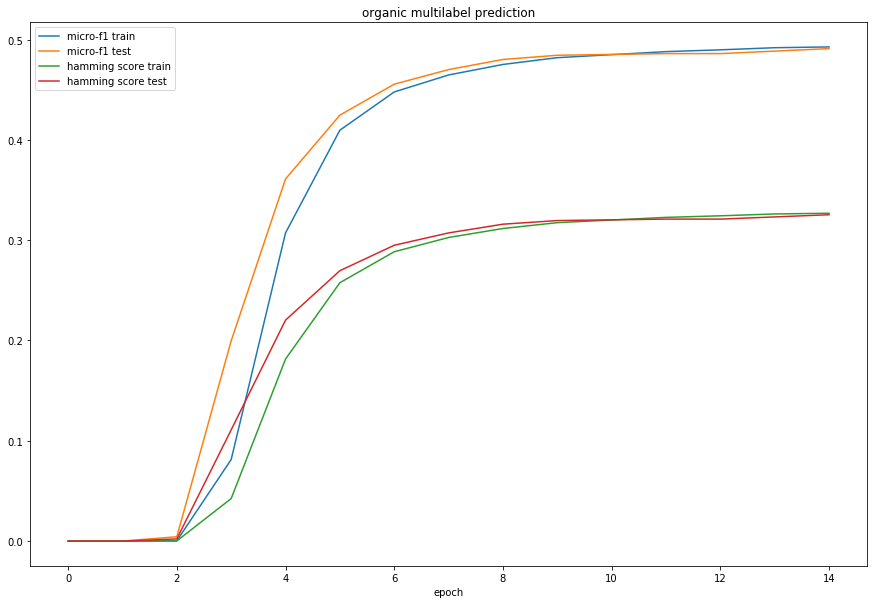

In [40]:
plt.figure(figsize=(15,10))

plt.plot( [f1_score(np.array(epoch[0]), np.array(epoch[1]),average="micro") for epoch in lab_pred_hist_train] , label="micro-f1 train")
plt.plot( [f1_score(np.array(epoch[0]), np.array(epoch[1]),average="micro") for epoch in lab_pred_hist_test] , label="micro-f1 test")

#plt.plot( [f1_score(np.array(epoch[0]), np.array(epoch[1]),average="macro") for epoch in lab_pred_hist_train] , label="macro-f1 train")
#plt.plot( [f1_score(np.array(epoch[0]), np.array(epoch[1]),average="macro") for epoch in lab_pred_hist_test] , label="macro-f1 test")

plt.plot( [hamming_score(np.array(epoch[0]), np.array(epoch[1])) for epoch in lab_pred_hist_train] , label="hamming score train")
plt.plot( [hamming_score(np.array(epoch[0]), np.array(epoch[1])) for epoch in lab_pred_hist_test] , label="hamming score test")

plt.legend()
plt.xlabel("epoch")
plt.title("organic multilabel prediction")
#plt.savefig("blobs/organic_multilabel_results.png")
#plt.savefig("imgs/organic_multilabel_results.png")
plt.show()